In [95]:
import numpy as np
import pandas as pd
import glob
import os

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from stesml.data_tools import load_data
from stesml.data_tools import get_train_and_test_data
from stesml.data_tools import get_train_and_test_index

from stesml.plot_tools import plot_test_results
from stesml.plot_tools import plot_average_error

In [96]:
%load_ext tensorboard
import datetime
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [97]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir, 
    histogram_freq=1,
)

2022-06-30 13:26:59.678965: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2022-06-30 13:26:59.678982: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2022-06-30 13:26:59.679020: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.


In [110]:
earlystopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=2,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

In [99]:
data_dir = "../data/Sulfur_Models/"

scenario_index = pd.DataFrame({"filepath": glob.glob(os.path.join(data_dir, "ML_*_*.csv"))})

In [100]:
target = 'Tavg'
scale = True

In [101]:
# Get the train and test index by randomly splitting up data (80-20 train-test split)
train_index, test_index = get_train_and_test_index(scenario_index)

In [102]:
# Get train and test data
X_train, y_train, X_test, y_test, scaler_x, scaler_y = get_train_and_test_data(scenario_index, train_index, test_index, target, scale)

In [135]:
# Get the model
model = Sequential()
model.add(Dense(50, activation='relu', input_shape=(3,)))
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.build()

In [136]:
model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_72 (Dense)             (None, 500)               2000      
_________________________________________________________________
dense_73 (Dense)             (None, 500)               250500    
_________________________________________________________________
dense_74 (Dense)             (None, 1)                 501       
Total params: 253,001
Trainable params: 253,001
Non-trainable params: 0
_________________________________________________________________


In [124]:
# Fit the model to training data
model.fit(x=X_train, 
          y=y_train,
          batch_size=1000,
          epochs=20,
          validation_data=(X_test, y_test),
          callbacks=[earlystopping_callback])

Epoch 1/20
2022/2022 [==============================] - 2s 1ms/step - loss: 0.1833 - val_loss: 0.0086
Epoch 2/20
2022/2022 [==============================] - 2s 914us/step - loss: 0.0024 - val_loss: 0.0053
Epoch 3/20
2022/2022 [==============================] - 2s 967us/step - loss: 0.0013 - val_loss: 0.0043
Epoch 4/20
2022/2022 [==============================] - 2s 878us/step - loss: 0.0011 - val_loss: 0.0037
Epoch 5/20
2022/2022 [==============================] - 2s 862us/step - loss: 8.6642e-04 - val_loss: 0.0036
Epoch 6/20
2022/2022 [==============================] - 2s 932us/step - loss: 8.2435e-04 - val_loss: 0.0035
Epoch 7/20
2022/2022 [==============================] - 2s 1ms/step - loss: 7.9417e-04 - val_loss: 0.0037
Epoch 8/20
2022/2022 [==============================] - 2s 880us/step - loss: 7.6869e-04 - val_loss: 0.0033
Epoch 9/20
2022/2022 [==============================] - 2s 974us/step - loss: 7.0200e-04 - val_loss: 0.0033
Epoch 10/20
2022/2022 [=========================

In [125]:
# Get predictions for test data
y_hat = model.predict(X_test)

In [126]:
y_hat = scaler_y.inverse_transform(y_hat.reshape(-1,1)).reshape(1,-1)[0]
y_test = scaler_y.inverse_transform(y_test.reshape(-1,1)).reshape(1,-1)[0]

In [127]:
# Evaluate results
rmse = mean_squared_error(y_test, y_hat, squared=False)
print(rmse)

3.012379281808231


In [128]:
r2 = r2_score(y_test, y_hat)
print(r2)

0.9959150711242518


In [129]:
test_df = load_data(scenario_index, test_index)
test_df[target+"_hat"] = y_hat

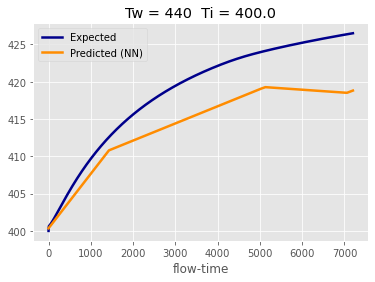

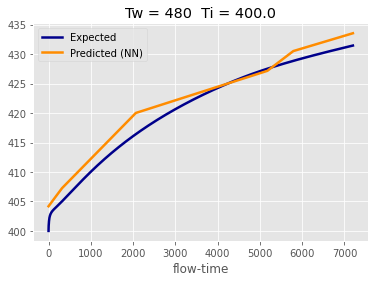

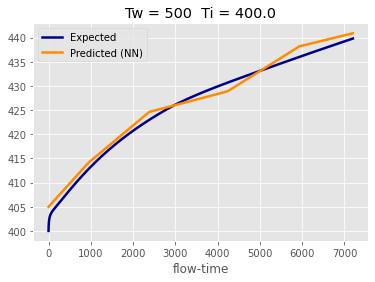

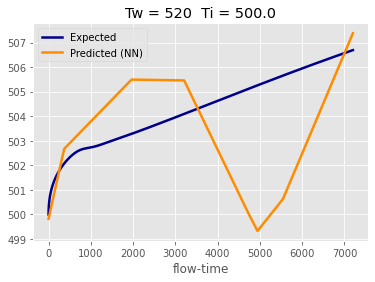

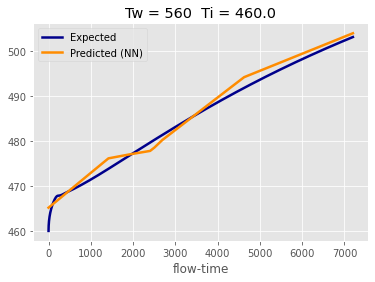

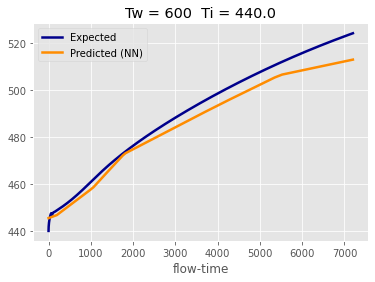

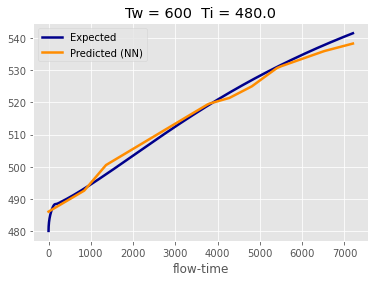

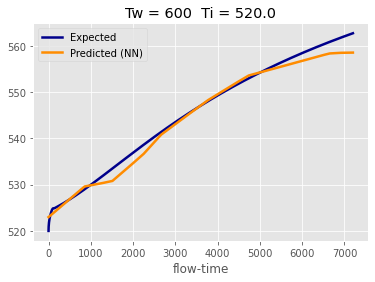

In [130]:
plot_test_results(test_df, 'NN', target)